<center><h1>Методы Монте-Карло и машинное обучение</h1></center>

In [1]:
!python -V # Версия Python

Python 3.12.8


In [2]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

### Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import randn
import torchmetrics
import polars as pl
import pandas as pd
import sklearn
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import jupyterlab as jlab
import ipywidgets
import random

from torchmetrics.audio import PerceptualEvaluationSpeechQuality, ShortTimeObjectiveIntelligibility

In [4]:
### Версии необходимых библиотек
packages = [
    "Torch", "Torchmetrics", "NumPy", "Polars", "Pandas", "Seaborn", "Matplotlib", "Scipy", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, torchmetrics, np, pl, pd, sns, mpl, scipy, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""Torchmetrics""","""1.6.1"""
3,"""NumPy""","""1.26.4"""
4,"""Polars""","""1.19.0"""
5,"""Pandas""","""2.2.3"""
6,"""Seaborn""","""0.13.2"""
7,"""Matplotlib""","""3.10.0"""
8,"""Scipy""","""1.15.1"""
9,"""Ipywidgets""","""8.1.5"""


# Лекция-семинар 5

6. **Монте-Карло для улучшения речи (Speech Enhancement).**
    - Применение методов Монте-Карло для оценки и оптимизации моделей улучшения речи, таких как MP-SENet
    - Обсуждение методов повышения качества звука и анализа ошибок с использованием Монте-Карло

## Акустические данные

### Оценка качества звука: Signal-to-Noise Ratio (SNR)

#### Что такое SNR?

**Signal-to-Noise Ratio (SNR)** - метрика, которая измеряет уровень полезного сигнала по сравнению с шумом. Она широко используется в обработке звука, связи и машинном обучении

#### Интуитивное понимание

- **Высокий SNR** означает, что полезный сигнал преобладает над шумом
- **Низкий SNR** указывает на сильное шумовое загрязнение

### Применение SNR в улучшении речи

- В **шумоподавлении** (*Speech Enhancement*) модели пытаются **максимизировать SNR**
- В **кодировании звука** (MP3, AAC) оценивается влияние сжатия на **соотношение сигнал-шум**
- В **разработке слуховых аппаратов** высокая SNR важна для **разборчивости речи**

### Математическая основа SNR

#### Формула SNR в децибелах (dB)

SNR определяется как логарифмическое отношение мощности полезного сигнала к мощности шума

$$
SNR = 10 \log_{10} \frac{P_{signal}}{P_{noise}}
$$

где:

- $P_{signal}$ - мощность полезного сигнала
- $P_{noise}$ - мощность шума

#### Вычисление мощности сигнала

Среднеквадратичное значение (*RMS - Root Mean Square*) мощности определяется как

$$
P = \frac{1}{N} \sum_{i=1}^{N} x_i^2
$$

Для дискретного звукового сигнала $x[n]$ и шума $n[n]$ это можно записать как

$$
SNR = 10 \log_{10} \frac{\sum_{n} x[n]^2}{\sum_{n} n[n]^2}
$$

Изначальный SNR: 7.40 дБ


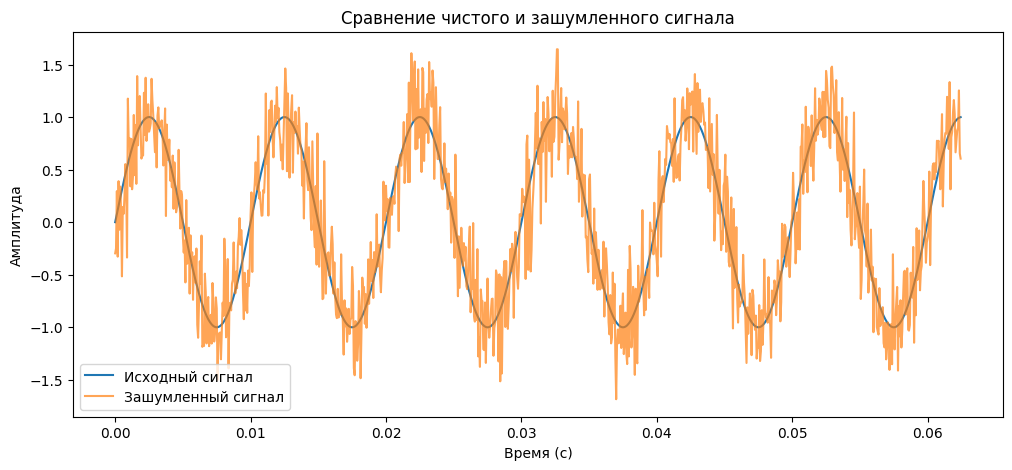

In [5]:
# Вычисление SNR
# Генерация сигнала и шума, расчет SNR
# Генерация синусоидального сигнала и шума
fs = 16000 # Частота дискретизации
T = 1 # Длительность сигнала в секундах
t = np.linspace(0, T, fs * T, endpoint = False)
signal = np.sin(2 * np.pi * 100 * t) # 100 Гц

# Добавление случайного гауссового шума
noise_level = 0.3 # Регулирование уровня шума
noise = noise_level * np.random.randn(len(t))
noisy_signal = signal + noise

# Вычисление SNR
def compute_snr(signal, noise):
    power_signal = np.mean(signal**2)
    power_noise = np.mean(noise**2)
    return 10 * np.log10(power_signal / power_noise)

snr_value = compute_snr(signal, noise)
print(f"Изначальный SNR: {snr_value:.2f} дБ")

# Визуализация сигнала до и после добавления шума
plt.figure(figsize = (12, 5))
plt.plot(t[:1000], signal[:1000], label = "Исходный сигнал")
plt.plot(t[:1000], noisy_signal[:1000], label = "Зашумленный сигнал", alpha = 0.7)
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.title("Сравнение чистого и зашумленного сигнала")
plt.legend()
plt.show()

### Улучшение SNR методом бутстрэпинга

Метод бутстрэпинга позволяет оценить стабильность SNR при различных подвыборках данных

Доверительный интервал SNR: [7.30, 7.50] дБ


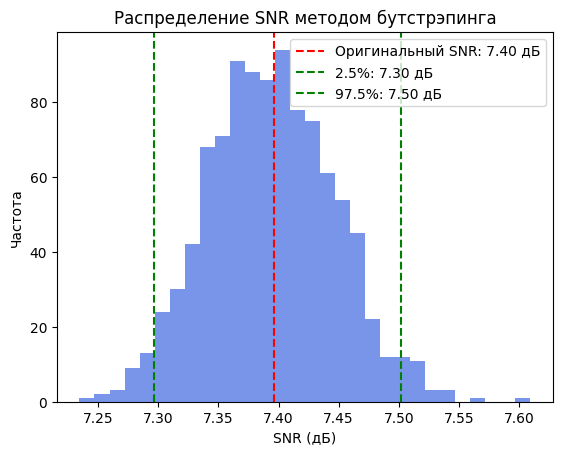

In [6]:
# Улучшение SNR методом бутстрэпинга
n_bootstrap = 1000
snr_samples = []

for _ in range(n_bootstrap):
    idx = np.random.choice(len(t), size = len(t), replace = True)
    snr_samples.append(compute_snr(signal[idx], noise[idx]))

# Оценка доверительного интервала для SNR
snr_lower, snr_upper = np.percentile(snr_samples, [2.5, 97.5])
print(f"Доверительный интервал SNR: [{snr_lower:.2f}, {snr_upper:.2f}] дБ")

# Визуализация распределения SNR
plt.hist(snr_samples, bins = 30, color = "royalblue", alpha = 0.7)
plt.axvline(snr_value, color = "red", linestyle = "dashed", label = f"Оригинальный SNR: {snr_value:.2f} дБ")
plt.axvline(snr_lower, color = "green", linestyle = "dashed", label = f"2.5%: {snr_lower:.2f} дБ")
plt.axvline(snr_upper, color = "green", linestyle = "dashed", label = f"97.5%: {snr_upper:.2f} дБ")
plt.xlabel("SNR (дБ)")
plt.ylabel("Частота")
plt.title("Распределение SNR методом бутстрэпинга")
plt.legend()
plt.show()

### Выводы

- **SNR - важная метрика качества звука**, измеряющая соотношение полезного сигнала к шуму
- **Формула SNR** основана на соотношении мощности сигнала и шума в логарифмической шкале
- **Методы Монте-Карло** помогают
    - **Бустрэпинг** - оценить доверительный интервал SNR
    - **Байесовская оптимизация** - подобрать параметры фильтрации шума для максимального SNR
    - **Dropout-оценка неопределенности** - снизить шум путем регуляризации моделей

## Perceptual Evaluation of Speech Quality (PESQ)

### Что такое PESQ?

**Perceptual Evaluation of Speech Quality (PESQ)** - это стандартная метрика оценки качества речи, учитывающая перцептивные особенности человеческого слуха. Она широко применяется в телекоммуникациях, VoIP и системах шумоподавления

### Математическая основа

PESQ рассчитывается на основе **исходного чистого сигнала** $x(t)$ и **искаженного сигнала** $y(t)$

1. **Приведение сигналов к единому формату** (например, 8 кГц или 16 кГц)
2. **Моделирование слухового восприятия**
    - Частотное преобразование (масштаб Bark)
    - Маскирование и временные искажения
3. **Расчет перцептивной разницы** между $x(t)$ и $y(t)$
4. **Агрегация ошибок** и вычисление итогового балла
    $$
    PESQ = a_1 \times D_{distortion} + a_2 \times D_{asymmetry} + b
    $$

    где: $D_{distortion}$ - искажения, $D_{asymmetry}$ - асимметричные шумы, а $a_1, a_2, b$ - эмпирические коэффициенты

PESQ Score: 1.16574


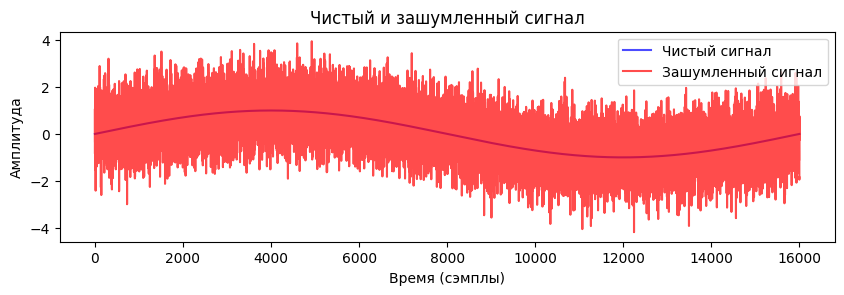

In [7]:
# Частота дискретизации (8000 или 16000 Гц)
fs = 16000

# Генерация тестовых сигналов
clean_signal = torch.sin(2 * np.pi * torch.linspace(0, 1, fs)) # Чистый сигнал
noisy_signal = clean_signal + torch.randn(fs) * 0.9 # Добавление шума

# Создание объекта метрики PESQ
pesq_metric = PerceptualEvaluationSpeechQuality(fs, mode = "wb") # wideband mode

# Вычисление PESQ
pesq_score = pesq_metric(noisy_signal, clean_signal)
print(f"PESQ Score: {pesq_score:.5f}")

# Визуализация
plt.figure(figsize = (10, 6))

# График чистого и зашумленного сигнала
plt.subplot(2, 1, 1)
plt.plot(clean_signal.numpy(), label = "Чистый сигнал", color = "b", alpha = 0.7)
plt.plot(noisy_signal.numpy(), label = "Зашумленный сигнал", color = "r", alpha = 0.7)
plt.title("Чистый и зашумленный сигнал")
plt.xlabel("Время (сэмплы)")
plt.ylabel("Амплитуда")
plt.legend()

### Улучшение PESQ с помощью методов Монте-Карло

Методы Монте-Карло позволяют случайным образом **подбирать параметры фильтрации**, а затем **выбирать лучшие** по метрике PESQ

## STOI (Short-Time Objective Intelligibility Measure)

### Что такое STOI?

**STOI** - объективная мера разборчивости речи, которая оценивает, насколько хорошо воспринимается речь человеком, особенно в условиях искажений, таких как шум, снижение качества через кодеки или бинарное маскирование. STOI широко используется в задачах, где важно оценить разборчивость и качество обработанных аудиофайлов, например, в системах шумоподавления или улучшения качества речи

### Математическая основа

Метрика STOI оценивает разборчивость речи с помощью анализа спектральных характеристик сигналов. Для этого используется несколько шагов:
1. **Разбиение сигнала на окна (Frame Segmentation)**
    - Сигнал разделяется на небольшие временные окна, например, длиной в 20-40 мс с перекрытием
    - Эти окна являются основой для анализа, так как в реальном мире речь не является статичной, а изменяется во времени
2. **Вычисление спектра**
    - Для каждого окна вычисляются спектральные характеристики, такие как амплитуда и фаза. Обычно для этого используется преобразование Фурье (FFT)
    - Спектр предоставляет информацию о частотных компонентах сигнала в каждой момент времени
3. **Кросс-корреляция спектров**
   - После вычисления спектра для каждого окна, сравнивается чистая речь (target) и искаженная (predicted) речь с помощью кросс-корреляции спектров
   - Кросс-корреляция измеряет степень сходства между спектрами чистой и искаженной речи
4. **Нормализация и вычисление STOI**
   - Полученная корреляция нормализуется для получения оценки разборчивости, которая будет в диапазоне от 0 до 1
   - Нормализация позволяет учесть различия в длине сигналов и их амплитудах

Итоговая метрика STOI представляет собой среднюю разборчивость на всех временных окнах

### Описание STOI

1. Разбиение сигнала $s(t)$ на окна $w_n$, где $t$ - время, а $n$ - индекс окна
2. Для каждого окна вычисляется спектр с помощью преобразования Фурье $S(w_n)$
3. Для каждого окна вычисляется корреляция между чистым сигналом $S_{target}(w_n)$ и искаженным сигналом $S_{pred}(w_n)$
   
$$
\text{Corr}(w_n) = \frac{\sum (S_{target}(w_n) \times S_{pred}(w_n))}{\sqrt{\sum S_{target}(w_n)^2 \times \sum S_{pred}(w_n)^2}}
$$

4. Итоговый результат STOI - это усредненная разборчивость на всех временных окнах
   
$$
\text{STOI} = \frac{1}{N} \sum_{n=1}^{N} \text{Corr}(w_n)
$$

где $N$ - количество окон

Результат STOI выражается в диапазоне от 0 до 1, где:
- **1** - максимальная разборчивость речи
- **0** - полная нечитаемость речи

In [8]:
preds = randn(8000)
target = randn(8000)
stoi = ShortTimeObjectiveIntelligibility(8000, False)

# Вычисление STOI
result = stoi(preds, target)
print(f"STOI: {result.item():.4f}")

STOI: -0.0243


## MP-SENet

### Улучшение речи с помощью методов Монте-Карло и машинного обучения в условиях реальных сценариев

#### Введение

В реальных условиях сигналы речи искажаются шумами и саморефлексиями от окружающих объектов. В узкополосных каналах сохраняются только низкочастотные компоненты, что ухудшает качество работы автоматического распознавания речи, слуховых аппаратов и телекоммуникационных систем

#### Проблемы

- Искажения из-за шума
- Потеря высокочастотных компонентов
- Снижение разборчивости и качества речи

#### Цель улучшения речи (SE)

Улучшение речи (SE) направлено на восстановление исходных сигналов и повышение их разборчивости и качества

#### Использование DNN для улучшения речи

Методы на основе глубоких нейросетей (DNN) решают проблемы искажений и восстановления речи
1. **Автоматизация** - минимизация ручной настройки
2. **Подавление шума** - восстановление важной информации
3. **Реальное время** - применение в слуховых аппаратах и телекоммуникациях


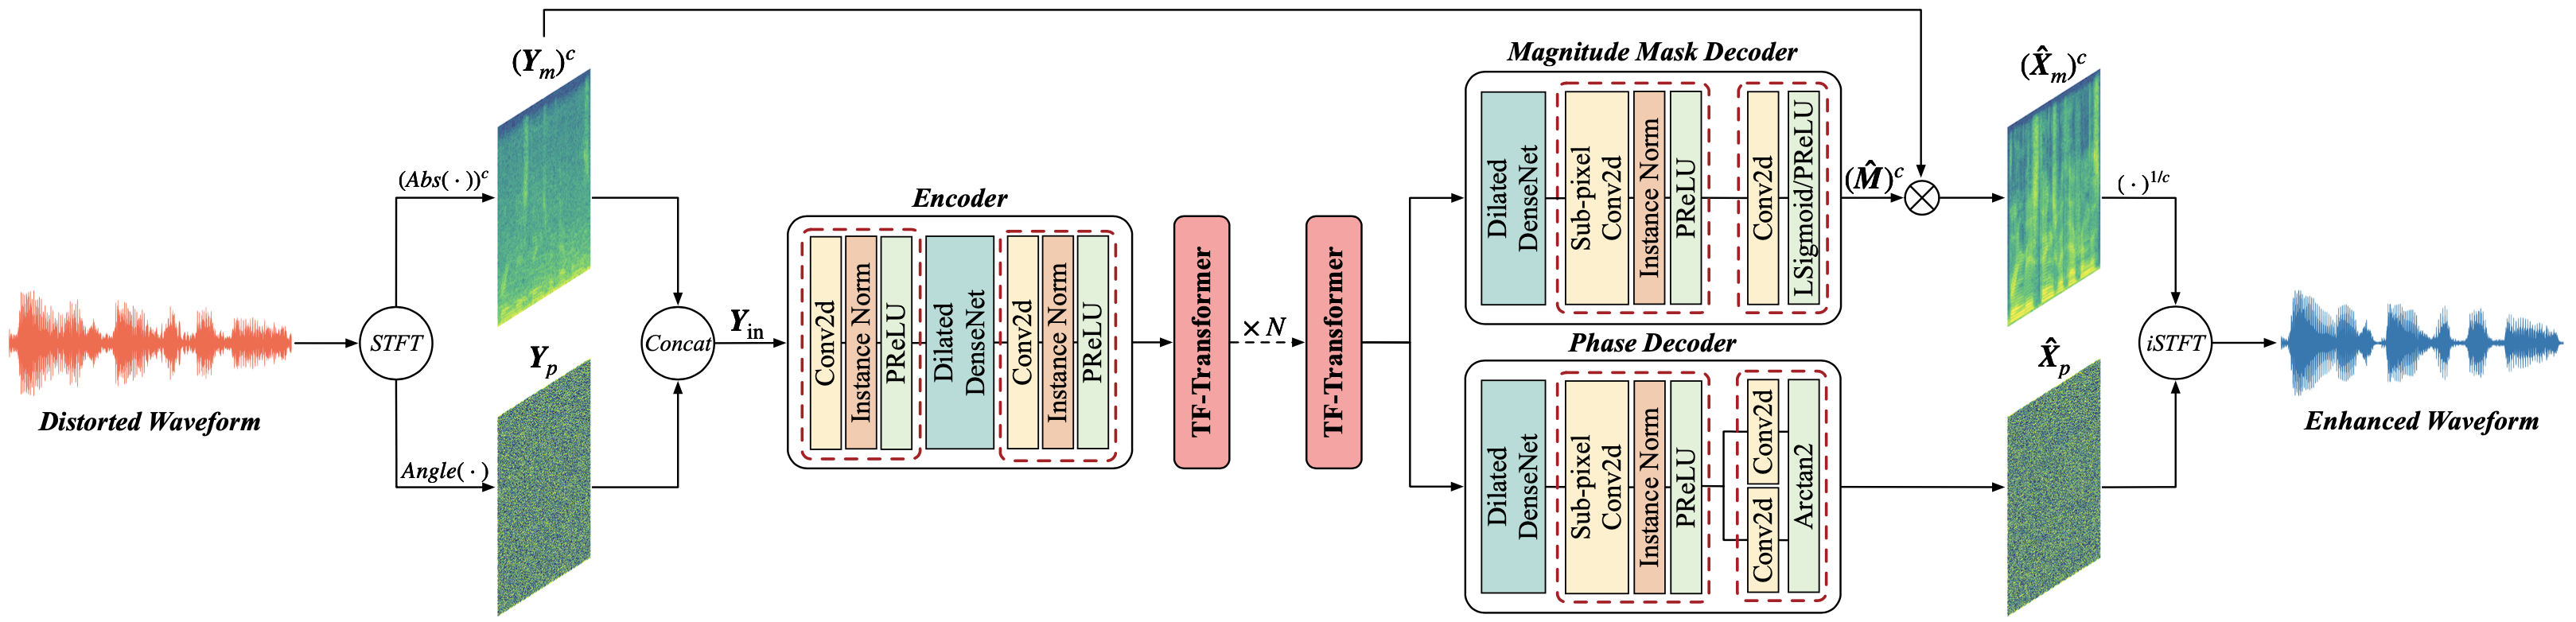

### Структура модели

1) Модель направлена на подавления шума, декорреляции и улучшения качества звука. Все эти задачи используют одинаковую архитектуру. В основе модели лежит структура энкодера-декодера, которая позволяет улучшить и восстановить исходный звуковой сигнал $y \in \mathbb{R}^L$ в TF (временная и частотная) области, где $L$ — длина сигнала. Сперва применяется STFT (краткосрочное преобразование Фурье) для извлечения комплексного спектра $Y \in \mathbb{C}^{T \times F}$, после чего вычисляются:
    - Магнитудный спектр $Y_m \in \mathbb{R}^{T \times F}$
    - Обернутый фазовый спектр $Y_p \in \mathbb{R}^{T \times F}$, где $Y = Y_m \times e^{jY_p}$
   
    где $T$ - количество кадров, а $F$ - количество частотных бинов

Далее нужно применить сжатие мощности на $Y_m$, чтобы получить сжатый магнитудный спектр $(Y_m)_c \in \mathbb{R}^{T \times F}$, где $c$ - фактор сжатия. Входной признак для MP-SENet $Y_{in} \in \mathbb{R}^{T \times F \times 2}$ является конкатенацией$(Y_m)_c$ и $Y_p$. Энкодер преобразует этот вход в сжатое представление в TF-области, которое затем обрабатывается $N$ блоками трансформеров времени и частоты (TF-Transformer) для захвата зависимостей во временной и частотной областях. На последнем этапе параллельный декодер для магнитуды и фазовый декодер прогнозируют сжатый магнитудный спектр $(\hat{X_m})_c \in \mathbb{R}^{T \times F}$ и обернутый фазовый спектр $\hat{X_p} \in \mathbb{R}^{T \times F}$, соответственно, из TF-представления

Восстановленный сигнал $\hat{x}$ получается через обратное STFT

2) **Энкодер** преобразует входной признак $Y_{in}$ в представление в TF-области с $C$ каналами, $T$ временными измерениями и $F' = F/2$ частотными измерениями. Он состоит из каскада сверток и функций активации

Первый блок увеличивает количество каналов в TF-представлении до $C$, а второй уменьшает размерность частоты с $F$ до $F'$, что помогает снизить вычислительную сложность в последующих блоках TF-Transformer. DenseNet использует N слоев свертки с различными размерами дилатации, чтобы расширить область восприятия вдоль временной оси. Кроме того, DenseNet использует связи, которые соединяют все предыдущие слои. Это предотвращает проблему исчезающих градиентов и повышает эффективность использования параметров

3) **TF-Transformer** направлен на захват дальнодействующих зависимостей как во временной, так и в частотной области. Структура основана на двухступенчатом внимании, и позволяет последовательно захватывать долгосрочные корреляции в этих областях. Входное представление для блока TF-Transformer имеет форму $B \times C \times T \times F'$, где $B$ - размер батча. Это представление сначала преобразуется в $BF' \times T \times C$ и передается через Time-Transformer для захвата зависимостей во времени. Затем оно преобразуется в $BT \times F' \times C$ и передается через Frequency-Transformer для захвата зависимостей по частоте. После обработки в этих блоках выходное представление снова преобразуется в $B \times C \times T \times F'$

В каждом блоке TF-Transformer и Time-Transformer, и Frequency-Transformer используют одинаковую архитектуру, основанную на GRU

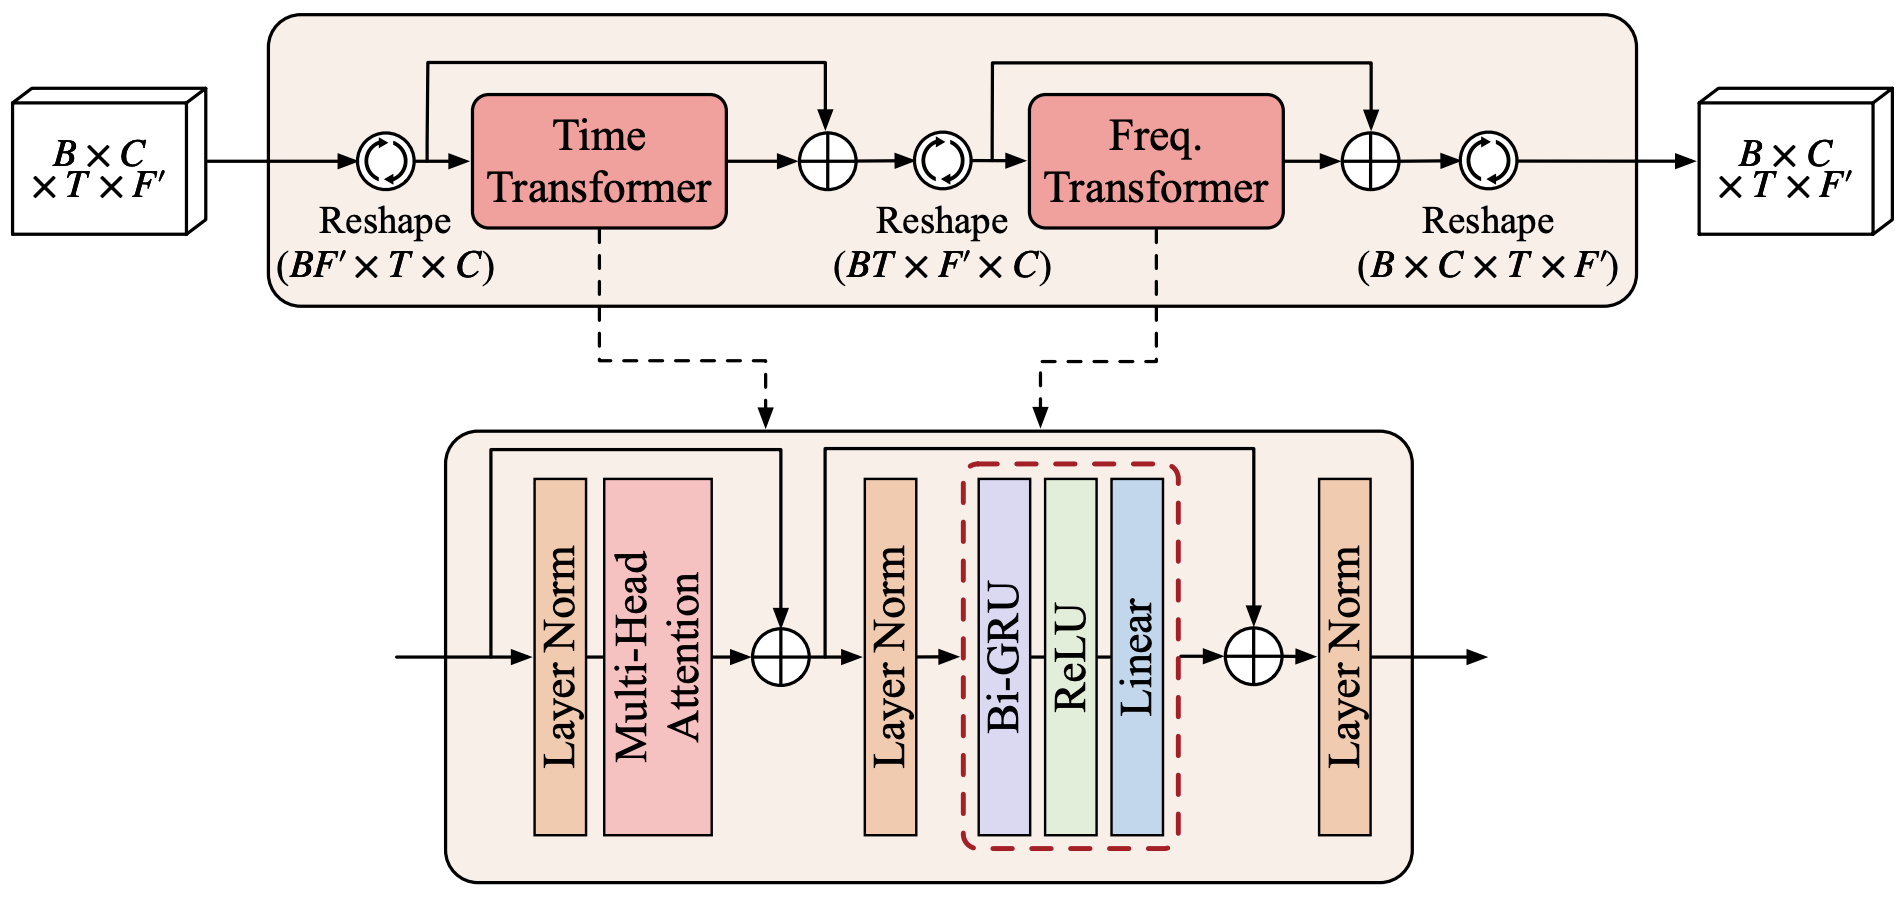

4) **Декодер магнитуды** предсказывает сжатую магнитудную маску $\hat{M}_c \in \mathbb{R}^{T \times F}$ из представления TF-области, обработанного блоками TF-Transformer, и умножает ее на сжатый магнитудный спектр $(Y_m)_c$, чтобы получить улучшенный сжатый магнитудный спектр $\hat{X}_m^c$

5) **Фазовый декодер** предсказывает улучшенный фазовый спектр $\hat{X}_p$. Архитектура фазового декодера схожа с декодером магнитудной маски, но с учетом проблемы фазы.

## Домашнее задание: Модификация модели MP-SENet с использованием различных архитектур и методов Монте-Карло

### Цель

Взять модель **MP-SENet**, изменить ее архитектуру (например, модифицировать блок Transformer или заменить его на другую архитектуру), обучить модель с использованием ваших вычислительных ресурсов и применить методы **Монте-Карло** для оптимизации или оценки результатов

### Шаги выполнения задания

#### Изучение модели MP-SENet

- Ознакомиться с архитектурой [MP-SENet](https://github.com/DmitryRyumin/MP-SENet/), особенно с блоком **TF-Transformer**, который используется для захвата зависимостей во временной и частотной областях

#### Модификация модели

- **Заменить или модифицировать блок Transformer**
    - Выберать архитектуру, которую хотелось бы использовать вместо **TF-Transformer**. Это может быть, например, **LSTM**, **GRU**, **TCN**, или другой тип трансформера в зависимости от ваших вычислительных ресурсов
    - Изменить код модели так, чтобы новая архитектура могла обрабатывать как временные, так и частотные зависимости
- **Адаптация параметров**
    - Подобрать оптимальные гиперпараметры для новой архитектуры, учитывая ограничение по вычислительным ресурсам. Важными параметрами будут размер слоев, количество голов в механизме внимания, размеры ядра свертки и другие

#### Обучение модели

- Использовать имеющиеся данные для обучения модели - [VoiceBank+DEMAND](https://datashare.ed.ac.uk/handle/10283/2791)
- Примените стандартные методы оптимизации и регуляризации

#### Применение методов Монте-Карло
- Используйте **методы Монте-Карло** для:
  1. **Оценки неопределенности модели** - применить **Марковские цепи Монте-Карло**, чтобы оценить различные возможные сценарии для улучшения качества звука или подавления шума
  2. **Оптимизации гиперпараметров** - применить методы, такие как **Гиббса** или **метод случайных поисков (Random Search)**, для настройки гиперпараметров модели (например, количество блоков, размер слоев, коэффициенты регуляризации)
- Использовать результаты методов Монте-Карло для адаптации модели и улучшения ее работы

#### Оценка и анализ результатов

- После обучения модели примените ее к тестовым данным и оцените качество с помощью соответствующих метрик, таких как **SNR**, **PESQ**, **STOI**

#### Сделать выводы